# FVG BASE

Purpose of this code to help me fix my larger FVG code. My orignal code started with many confleucnes and more intricate details and thus was very hard to debug. Thus I made this more basic fvg code, only keeping the neccesary parts for the fucntoning of the basic code.


In [18]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import yfinance as yf
from backtesting import Backtest, Strategy
import multiprocessing
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates

multiprocessing.set_start_method('fork', force=True)

# This is the code to help debug the main fvg code, this just uses fvg's with no confleunces. 
# Basic as possible, no shorting
# Testing if the functioning of the code works

Class to detect FVG and check wether it is valid 

In [19]:
class detect_FVG:
    def __init__(self,
                 df,
                 min_gap_size=1,
                 max_candles=10,
                 ):
        """
        :param df: DataFrame
        :param min_gap_size: The minimum gap size required to consider a new FVG.
        :param max_candles: How many candles after zone test we allow for final validation.
        """
        self.df = df
        self.min_gap_size = min_gap_size
        self.max_candles = max_candles

        # Arrays/lists for signals
        self.signals = np.zeros(len(df))
        self.active_fvgs = []

        # OPTIONAL: heres another place could of called self.calculate_support()
        # below is intiallising the other columns 

        self.df["signal"] = 0
        self.df["fvg_low"] = np.nan
        self.df["fvg_high"] = np.nan
        self.df["fvg_type"] = None

    def run(self):
        
        # Main loop: single pass through df.
        
        n_bars = len(self.df)
        for i in range(2, n_bars):
            # 1) Try detecting a new bullish FVG at candle i
            self.detect_new_fvg(i)
            # 2) Update and validate all active FVGs with the latest candle i
            self.update_active_fvgs(i)

        return self.signals

    def detect_new_fvg(self, i):
        """
        Check if a new bullish or bearish FVG is formed at candle i:
        """

        # Extract candle values
        high_i2 = self.df['High'].iloc[i - 2]
        low_i = self.df['Low'].iloc[i]

        # optional logging
        #if i < 50:
         #print(f"Bar {i}: gap_size = {low_i - high_i2}, High[i-2]={high_i2}, Low[i]={low_i}")   

        low_i2 = self.df['Low'].iloc[i - 2]
        high_i = self.df['High'].iloc[i]

        fvg_types = [
            {
                "direction": "bullish",
                "fvg_low": high_i2,
                "fvg_high": low_i,
                "gap_size": low_i - high_i2,
                "threshold": high_i2 < low_i,
                "support_key": "on_recent_support"
            },
            {
                "direction": "bearish",
                "fvg_low": high_i,
                "fvg_high": low_i2,
                "gap_size": low_i2 - high_i,
                "threshold": low_i2 > high_i,
                "support_key": "on_recent_resistance"
            }
        ]


        for fvg in fvg_types:
            if fvg["gap_size"] >= self.min_gap_size and fvg["threshold"]:
                # print(f"FVG detected at bar {i}: direction={fvg['direction']}, gap_size={fvg['gap_size']}")  logging 

                fvg_dict = {
                    "start_idx": i,
                    "fvg_low": fvg["fvg_low"],
                    "fvg_high": fvg["fvg_high"],
                    "zone_tested": False,
                    "validation_candles": 0,
                    "BOS": False,
                    fvg["support_key"]: False,
                    "FVG_is_in_allowed_range": False,
                    "direction": fvg["direction"]
                }

                
                self.active_fvgs.append(fvg_dict)


    def update_active_fvgs(self, i):
        
        """
        1) For each active FVG, check if the new candle i "tests" the zone (if not tested).
        2) If tested, increment validation candle count, check final validation condition.
        3) Remove FVG if validated or expired.
        """

        current_candle = self.df.iloc[i]
        prev_candle = self.df.iloc[i - 1]
        to_remove = []

        for idx, fvg_dict in enumerate(self.active_fvgs):
            direction = fvg_dict["direction"]  # "bullish" or "bearish"
            fvg_low = fvg_dict["fvg_low"]
            fvg_high = fvg_dict["fvg_high"]

            if not fvg_dict['zone_tested']:
                if direction == "bullish":
                # Check if the new candle i "tests" the zone
                    tolerance = 0.005  # We dont optimise this  
                    if (current_candle['Low']*(1 - tolerance) <= fvg_high <= current_candle['High']*(1 + tolerance)):
                        
                        # If bullish close above fvg_high => immediate test
                        if (current_candle['Close'] > fvg_high
                            and current_candle['Close'] > prev_candle['Close']):
                            fvg_dict['zone_tested'] = True
                            fvg_dict['validation_candles'] = 0
                        elif (fvg_low < current_candle['Close'] < fvg_high
                            and current_candle['Close'] < prev_candle['Close']):
                            fvg_dict['zone_tested'] = True
                            fvg_dict['validation_candles'] = 0
            
                else:
                    if current_candle['High'] >= fvg_low >= current_candle['Low']:
                        # If new candle closes below the FVG low + is lower than prev close - zone tested
                        if (current_candle['Close'] < fvg_low
                                and current_candle['Close'] < prev_candle['Close']):
                            fvg_dict['zone_tested'] = True
                            fvg_dict['validation_candles'] = 0
                        # Or closes somewhere inside 
                        elif (fvg_high > current_candle['Close'] > fvg_low
                            and current_candle['Close'] > prev_candle['Close']):
                            fvg_dict['zone_tested'] = True
                            fvg_dict['validation_candles'] = 0


            else:
                fvg_dict['validation_candles'] += 1

                if direction == "bullish":
                # If close above fvg_high > final validation > produces signal
                    if current_candle['Close'] > fvg_dict['fvg_high']:
                        #print(f"Bullish final validation at bar {i}: Close={current_candle['Close']} fvg_high={fvg_dict['fvg_high']}")
                        #optional logging
                        # print(f"Bullish signal at bar {i}: Close={current_candle['Close']} > fvg_high={fvg_dict['fvg_high']}")  # to check if theres ever acc bullish signals 
                        self.signals[i] = 1
                        self.df.iloc[i, self.df.columns.get_loc('signal')]  = 1
                        self.df.iloc[i, self.df.columns.get_loc('fvg_low')] = fvg_low
                        self.df.iloc[i, self.df.columns.get_loc('fvg_high')] = fvg_high
                        self.df.iloc[i, self.df.columns.get_loc('fvg_type')] = 'bullish'
                        to_remove.append(idx)
                    else:
                        # If we exceeded max_candles discard
                        if fvg_dict['validation_candles'] >= self.max_candles:
                            to_remove.append(idx)
                
                else:
                    if current_candle['Close'] < fvg_low:
                        self.signals[i] = -1
                        self.df.iloc[i, self.df.columns.get_loc('signal')] = -1
                        self.df.iloc[i, self.df.columns.get_loc('fvg_low')] = fvg_low
                        self.df.iloc[i, self.df.columns.get_loc('fvg_high')] = fvg_high
                        self.df.iloc[i, self.df.columns.get_loc('fvg_type')] = 'bearish'

                        to_remove.append(idx)
                    else:
                        # If we exceeded max_candles discard
                        if fvg_dict['validation_candles'] >= self.max_candles:
                            to_remove.append(idx)

        # Remove validated or expired FVGs for efficiency
        for r_idx in reversed(to_remove):
            self.active_fvgs.pop(r_idx)

Due to the backtesting libary automaticly truncating/ padding the dataframe due to various circustances, 
I had to add this helper fucntion named apply signals. 
This ensures the signals array  and the dataframe have the same length.

In [20]:
def apply_signals(df, 
                  min_gap_size=1, 
                  max_candles=10):
    fvg_sp = detect_FVG(
        df,
        min_gap_size=min_gap_size,
        max_candles=max_candles,
    )
    signals = fvg_sp.run()
    # If the signals array length is less than the DataFrame index, pad with zeros.
    if len(signals) < len(df.index):
        pad_length = len(df.index) - len(signals)
        signals = np.concatenate([signals, np.zeros(pad_length)])
    # Or, if it is longer than the index, truncate it.
    elif len(signals) > len(df.index):
        signals = signals[:len(df.index)]
    return pd.Series(signals, index=df.index)


Class Mystrat is the actual trading logic 

In [21]:
class MyStrat(Strategy):
    min_gap_size= 1 
    max_candles= 10

    def init(self):
        super().init()
        self.signal1 = self.I(self.calculate_signal)

    def calculate_signal(self):
    # Computing the signals using the full DataFrame stored in self.data.df
        s = apply_signals(
            df=self.data.df, 
            min_gap_size=self.min_gap_size, 
            max_candles=self.max_candles, 
        )
        # Trim the signals to match the number of bars in the Backtest data.
        # (Backtesting has already dropped some rows, so len(self.data) is the trimmed length.)
        return s.iloc[-len(self.data):].values

    
    
    def next(self):
        super().next()
        current_price = self.data.Close[-1]
        last_signal = self.signal1[-1]    
        last_fvg_low = self.data.df['fvg_low'].iloc[-1]   
        last_fvg_high = self.data.df['fvg_high'].iloc[-1]
        last_fvg_type = self.data.df['fvg_type'].iloc[-1]

        #  strategy doesn't hold two trades at once
        if not self.position:
            # Bullish FVG signal
            if last_signal == 1:
                fvg_low = last_fvg_low
                fvg_high = last_fvg_high
                position_size = 1/10

                # 1) STOP-LOSS just below FVG low (some small buffer, e.g., 1%)
                sl_price = fvg_low * 0.99

                # 2) Partial TP at 1.5x risk
                risk = current_price - sl_price
                partial_tp_price = current_price + 1.5 * risk

                # Store for reference
                self.trade_info = {
                    "initial_sl": sl_price,
                    "partial_tp_price": partial_tp_price,
                    "remaining_position_sl": sl_price,  
                    "partial_taken": False,
                    "fvg_low": fvg_low,
                    "fvg_high": fvg_high,
                    "entry_price": current_price
                }

                # Place an initial buy order with that SL
                self.buy(sl=sl_price, size=position_size)
            
            elif last_signal == -1:
                fvg_low = last_fvg_low
                fvg_high = last_fvg_high
                position_size = 1/10

                # 1) STOP-LOSS just above FVG high (some small buffer, e.g. 1%)
                sl_price = fvg_high * 1.01

                # 2) Partial TP at 1.5x risk (risk = SL - entry, since SL is above entry)
                risk = sl_price - current_price
                partial_tp_price = current_price - 1.5 * risk

                # Store for reference
                self.trade_info = {
                    "initial_sl": sl_price,
                    "partial_tp_price": partial_tp_price,
                    "remaining_position_sl": sl_price,  # Will move downward for trailing
                    "partial_taken": False,
                    "fvg_low": fvg_low,
                    "fvg_high": fvg_high,
                    "entry_price": current_price
                }

                # Place an initial sell order with that SL
                if not np.isnan(sl_price) and sl_price is not None:
                    self.sell(sl=sl_price, size=position_size)
        
                else:
                    print("Warning: SL price is NaN or None. Skipping sell order.")

        else:
            #   MANAGE AN OPEN POSITION
            
            pos_size = abs(self.position.size)
            info = self.trade_info
            entry         = info["entry_price"]
            initial_sl    = info["initial_sl"]
            partial_tp    = info["partial_tp_price"]
            partial_taken = info["partial_taken"]
            remaining_sl  = info["remaining_position_sl"]
            pos_size = abs(self.position.size)
            trail_atr_mult = 1.0
            current_atr = self.data.ATR[-1]

            # LONG POSITION MANAGEMENT

            if self.position.size > 0:
            # Check partial TP
                if not partial_taken and (current_price >= partial_tp):
                    pos_size = abs(self.position.size)
                    # Check if we're dealing with fractional or whole units
                    if pos_size < 1:
                        half_size = pos_size / 2.0
                        #print(f"Long partial exit (fraction): pos_size = {pos_size}, half_size = {half_size}")
                        self.sell(size=half_size)
                        info["partial_taken"] = True
                    else:
                        half_size = int(round(pos_size / 2.0))
                        #print(f"Long partial exit (integer): pos_size = {pos_size}, half_size = {half_size}")
                        # Make sure half_size is at least 1
                        if half_size >= 1:
                            self.sell(size=half_size)
                            info["partial_taken"] = True
                        else:
                            print("Invalid partial exit size computed:", half_size)


                # If partial is taken, start trailing the remaining half
                if info["partial_taken"]:
                    new_sl = current_price - trail_atr_mult * current_atr
                    # Only move SL upward
                    if new_sl > remaining_sl:
                        info["remaining_position_sl"] = new_sl

                # If we drop below trailing SL, close out everything
                if current_price < info["remaining_position_sl"]:
                    self.position.close()

        #  SHORT POSITION MANAGEMENT
            elif self.position.size < 0:
                # Check partial TP (price goes down to partial_tp)
                if not partial_taken and (current_price <= partial_tp):
                    pos_size = abs(self.position.size)
                    if pos_size < 1:
                        half_size = pos_size / 2.0
                        #print(f"Short partial exit (fraction): pos_size = {pos_size}, half_size = {half_size}")
                        self.buy(size=half_size)
                        info["partial_taken"] = True
                    else:
                        half_size = int(round(pos_size / 2.0))
                        #print(f"Short partial exit (integer): pos_size = {pos_size}, half_size = {half_size}")
                        if half_size >= 1:
                            self.buy(size=half_size)
                            info["partial_taken"] = True
                        else:
                            print("Invalid partial exit size computed:", half_size)


                # If partial is taken, start trailing the remaining half
                if info["partial_taken"]:
                    new_sl = current_price + trail_atr_mult * current_atr
                    # Only move SL downward
                    if new_sl < remaining_sl:
                        info["remaining_position_sl"] = new_sl

                # If price rises above the trailing SL for a short, close out
                if current_price > info["remaining_position_sl"]:
                    self.position.close()

Now we run the backtest for each ticker 

In [22]:
def run_backtest_for_ticker(ticker, start='2024-01-01', end='2025-01-01', inerval='1d'):
    print(f"\n=== Backtesting {ticker} ===")
    df = yf.download(tickers=ticker, start=start, end=end, interval='1d')
    if df.empty:
        print(f"No data for {ticker}")
        return None
    
    # Standardise columns
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [' '.join(col).strip() for col in df.columns]
    df.columns = [col.split(' ')[0] for col in df.columns]

    # Manually compute ATR 
    df['ATR'] = ta.atr(df['High'], df['Low'], df['Close'], length=14)
    
    # Indicators
    df["signal"]   = 0
    df["fvg_low"]  = np.nan
    df["fvg_high"] = np.nan
    df["fvg_type"] = None
        
    # Backtest, dont worry about optimsising for this code 
    bt = Backtest(df, MyStrat, cash=10000, margin=1, commission=0.001) #pre test margin was 1/10
    stats = bt.optimize(
       min_gap_size=[0.01, 0.1,0.5, 1],
       maximize='Return [%]',
    )
    
    return (ticker, stats, bt)

Below is the final touch ups. 
Then the output ,where you would of seen:
- final validation logging as well as where fvg were detected (this was very helpful in debugging as it allowed me to know that it wasnt detect_fvg logic failig but the Mystrat class.
- You will also see logging to see wether the partial excit worked
- However due to jupyter notebook limiting the number of lines output iv commented the logging statments
- thus below you just see the logging of when each ticker has been complete as well as the results for each ticker with their optimal parameters at the bottom
- This is good as now I can work on trying to fix my larger code


[*********************100%***********************]  1 of 1 completed


=== Backtesting AAPL ===



[*********************100%***********************]  1 of 1 completed


=== Backtesting AMZN ===



[*********************100%***********************]  1 of 1 completed


=== Backtesting TSLA ===



[*********************100%***********************]  1 of 1 completed


=== Backtesting NVDA ===



===== AAPL results =====
Start                     2024-01-02 00:00...
End                       2024-12-31 00:00...
Duration                    364 days 00:00:00
Exposure Time [%]                    84.52381
Equity Final [$]                  10073.11115
Equity Peak [$]                   10137.11224
Return [%]                            0.73111
Buy & Hold Return [%]                 34.8955
Return (Ann.) [%]                     0.73111
Volatility (Ann.) [%]                   1.745
CAGR [%]                              0.50559
Sharpe Ratio                          0.41897
Sortino Ratio                          0.6467
Calmar Ratio                          0.68252
Max. Drawdown [%]                    -1.07119
Avg. Drawdown [%]                    -0.40042
Max. Drawdown Duration       83 days 00:00:00
Avg. Drawdown Duration       27 days 00:00:00
# Trades                                   23
Win Rate [%]                         52.17391
Best Trade [%]                       15.26176
Worst Tr

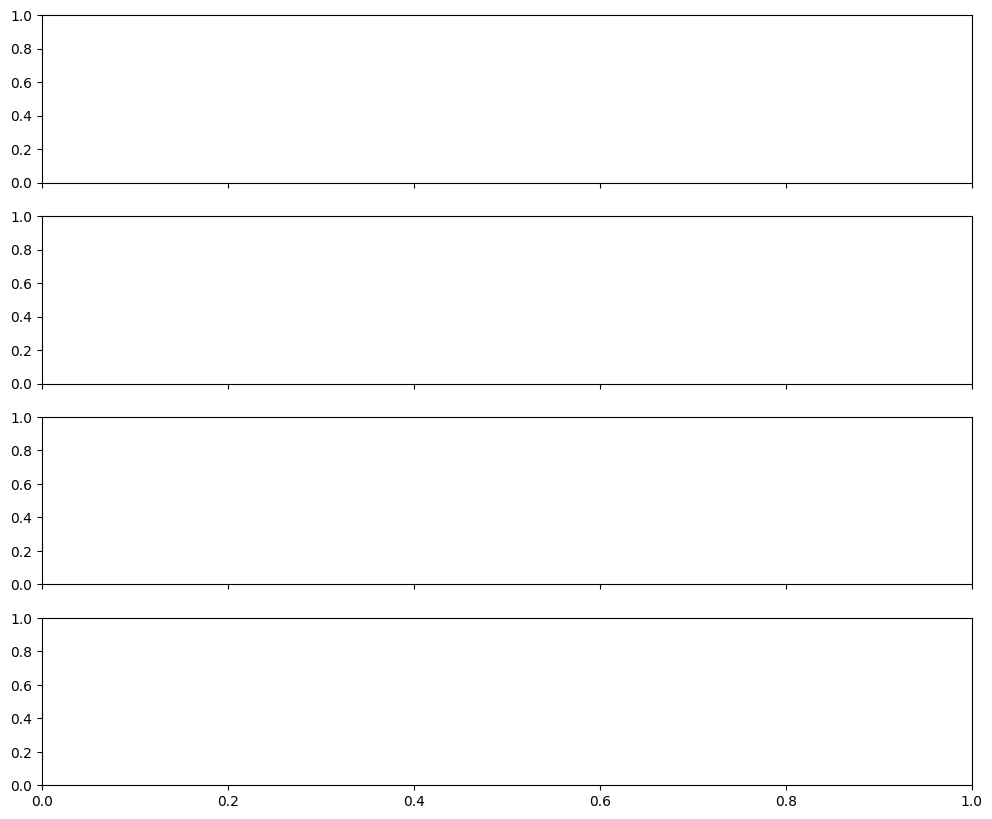

In [23]:
############################################################################### chat gpt always does these phsycial barriers and I like them, good visual aid
# 3. Run for multiple tickers
tickers = ["AAPL", "AMZN", "TSLA", "NVDA"]
results = []

for tk in tickers:
    out = run_backtest_for_ticker(tk)
    if out is not None:
        results.append(out)

if not results:
    print("No successful backtests to display.")

# 4. Plot each ticker in subplots
###############################################################################
fig, axes = plt.subplots(len(results), 1, figsize=(12, 10), sharex=True)
if len(results) == 1:
    axes = [axes]  # So we can iterate the same way

for ax, (ticker, stats, bt) in zip(axes, results):
    # Print the stats
    print(f"\n===== {ticker} results =====")
    print(stats)
    print("Optimal Parameters:")
    print(f"  Min gap size:        {stats._strategy.min_gap_size}")
